In [58]:
import difflib
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_colwidth', 100)

In [7]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# read in matched data
corpus_df = pd.read_pickle("matched_data.pickle")
corpus_wo_df = pd.read_pickle("matched_data_wo_abstracts.pickle")

In [89]:
def clean_text(text, skip=False):
    if not skip:
        allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9.,;:!?()'\"-]"
        text = re.sub(allowed_chars, ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
print(f'{corpus_df.shape=}\t\t{corpus_wo_df.shape=}')
print(f'Percent of data in full transcriptions:\t\t{corpus_wo_df.shape[0] / corpus_df.shape[0]:.1%}')

corpus_w_df.shape=(787468, 3)		corpus_wo_df.shape=(734664, 3)
Percent of data in full transcriptions:		93.3%


In [4]:
# could be cleaner - should numbers have been removed? should single newlines be replaced with spaces?
display(corpus_df.sample(10))
display(corpus_wo_df.sample(10))

,pub_number,fr,en
777162,SSR 2002/C6-10,Ces relevés ont finalement motivé une augmentation de du TAC qui est ainsi passé à t,"These surveys have ultimately resulted in an increase in TAC, to t"
193955,RES 2003/015,"Par conséquent, un rétablissement de la biomasse du stock\nde reproducteurs au cours des prochai...","Consequently, rebuilding of spawning biomass over the next few years is unlikely"
473740,RES 2024/045,( b) présentent les valeurs supérieures et inférieures des prélèvements potentiels de la pêche r...,"( b) present upper and lower values of potential recreational fishery removals, based on availab..."
450296,RES 2023/070,"), d autres indices sont peut-être plus pertinents pour les populations qui occupent des échelle...","), other indices are perhaps more relevant to populations that occupy smaller scales"
708486,SCR 2020/013,pl ie canadienne merluche blanche raie épineuse Année Régions du Québec et du Golfe Réponse des ...,Quebec and Gulf Regions Science Response: Decision support for authorizing surveys in Gulf of St
731247,SCR 2023/037,"Pour la majorité des espèces exploitées, la biomasse du stock produisant le rendement maximal du...","For the majority of exploited species, the stock biomass producing maximum sustainable yield (BM..."
630139,SAR 2021/029,est demeuré au-dessus du niveau de référence malgré une diminution des prises totales,has continued to remain above the reference level despite a decrease in total catch
428596,RES 2023/008,Mise en évidence de l effet de la compétition intraspécifique entre alevins et tacons de saumon ...,Spawning success in Atlantic salmon (Salmo salar L.): a long-term DNA profiling-based study cond...
553549,SAR 2013/011,On trouve des capelans juvéniles du stock de la sous-zone et des divisions KL dans les principal...,KL stock can be found both in major bays and in offshore waters although the northern Grand Bank...
754354,SSR 1998/B3-09,"En revanche, les débarquements des bateaux de pêche côtière augmentèrent de t en à t en","In contrast, landings by the inshore fleet increased from t in to t in"


,pub_number,fr,en
201376,RES 2015/062,"Dans l'ensemble, les tendances dans les zones présentant différentes plages de taux de capture s...","Overall, the trends in areas of various ranges of catch rates have been stable for the past five..."
146418,PRO 2024/024,"Cependant, certaines cotes de vulnérabilité se situent au niveau de l activité","However, some vulnerability scores are at the activity level"
175720,RES 2007/016,"Régression de l’abondance des classes-d’âge des géniteurs d’automne, avec retard",Regression of age-class abundance of fall spawners from one year to the next
255711,RES 2020/009,Plusieurs sépioles leucoptères (Stoloteuthis leucoptera) ont été recueillis en août lors du rele...,Several butterfly bobtail squid (Stoloteuthis leucoptera) were collected in August during the su...
592157,SAR 2023/003,Le futur relevé multispécifique pourra servir à suivre les changements de densité des invertébré...,Future multispecies surveys may be used to monitor changes in invertebrate densities over time i...
710342,SSR 2000/A3-34,Il conviendrait de réduire la mortalité par pêche de la plie canadienne jusqu'à ce qu'on observe...,There should be a reduction in fishing mortality on American plaice until an increase in product...
646133,SCR 2018/021,La moyenne géométrique de l'indice de la biomasse sur trois ans est représentée par la ligne noi...,The three year geometric mean biomass index is represented by the solid black line
121390,PRO 2022/016,Un nouveau projet est en cours pour utiliser la science citoyenne sur la côte Est afin de collec...,A new project is underway to use citizen science in the Eastern Shore to collect more data withi...
274443,RES 2020/058,viscosa dans les fermes d élevage de saumon atlantique de la région des îles Discovery Janv,viscosa on Atlantic Salmon farms in the Discovery Islands area Jan Feb Mar Apr May Jun Jul Aug S...
511486,SAR 2014/007,"Contexte : Le crabe des neiges, Chionoecetes opilio, est exploité commercialement dans le sud du...","Context: Snow crab, Chionoecetes opilio, has been commercially exploited in the southern Gulf of St"


In [5]:
memory_usage_mb = corpus_df.memory_usage(deep=True).sum() / (1024 ** 2)
memory_usage_wo_mb = corpus_wo_df.memory_usage(deep=True).sum() / (1024 ** 2)

print(f"DataFrame size (with abstracts): {memory_usage_mb:.1f} MB")
print(f"DataFrame size (without abstracts): {memory_usage_wo_mb:.1f} MB")

DataFrame size (with abstracts): 373.8 MB
DataFrame size (without abstracts): 347.0 MB


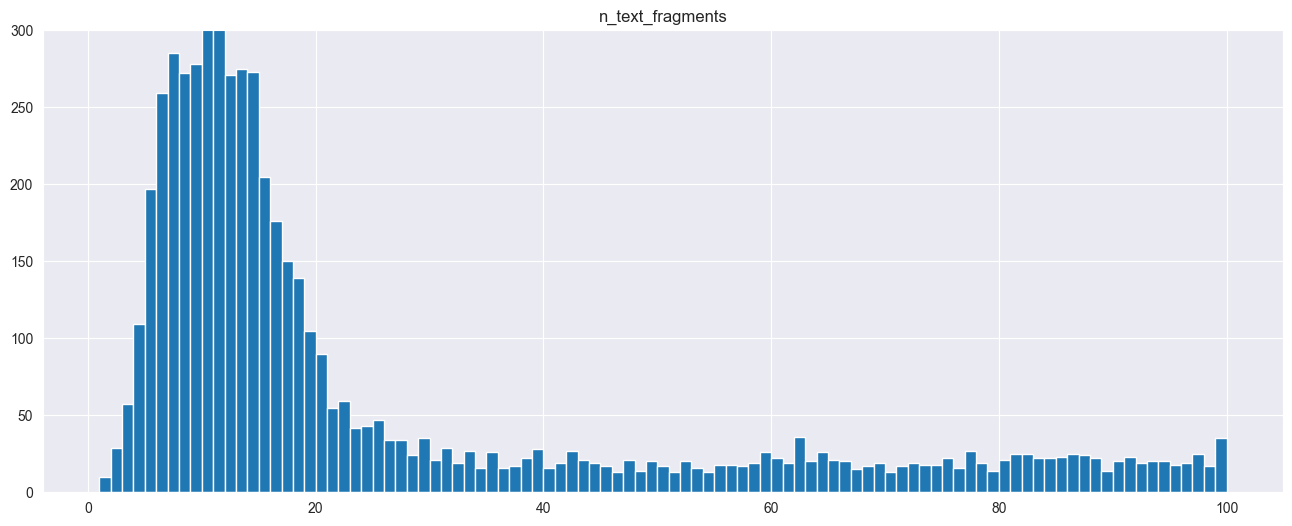

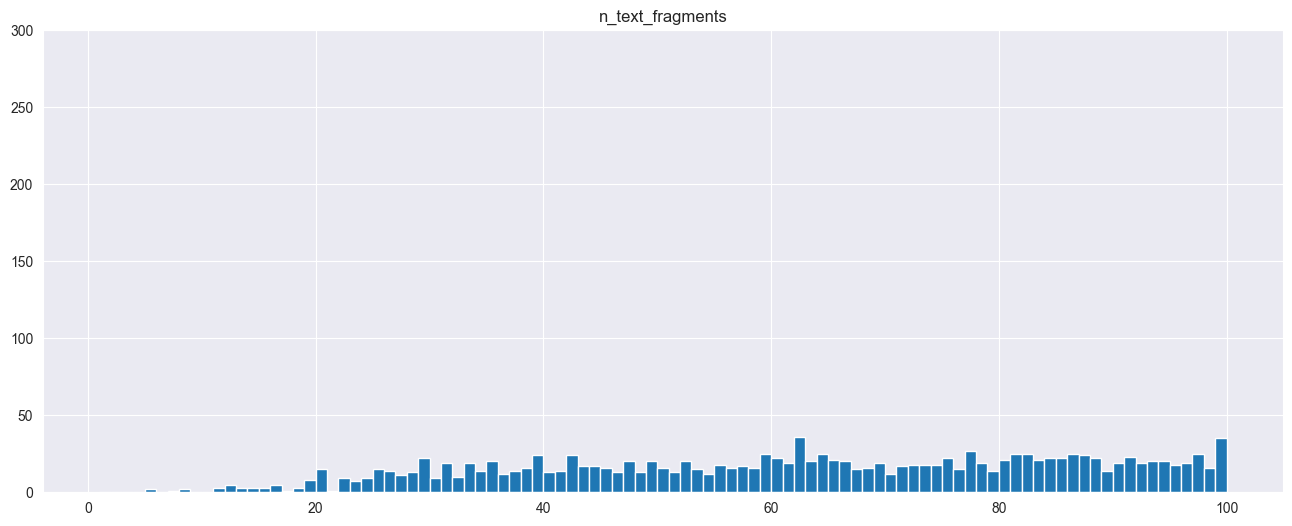

In [11]:
def plot_pub_number_hist(dataframe):
    corpus_value_counts = pd.DataFrame(dataframe.pub_number.value_counts())
    corpus_value_counts.columns = ['n_text_fragments']
    
    fig, ax = plt.subplots(figsize=(16, 6))
    corpus_value_counts[corpus_value_counts.n_text_fragments <= 100].hist(
        bins=[x + 1 for x in range(100)],
        ax=ax
    )
    ax.set_ylim(0, 300) 
    plt.show()

plot_pub_number_hist(corpus_df)
plot_pub_number_hist(corpus_wo_df)

In [ ]:
# TODO: data cleaning 
#  remove characters, numbers, etc? 
#  remove names, contact info, etc?